### Outline
 - Save information about the radio image files
 - Probe dendrogram values to find best source detection parameters
 - Use the dendrogram to save source regions to a catalog file
 - Reject bad sources
 - Match source detections between bands
 - Make flux measurements within several different aperture shapes
 - Flux flux plots
 - Flux histograms

### Image File Information
Here, I have already created a `.dat` file that contains information about each radio image file we'll be processing. Let's read it in and see what info we'll need from each file:

In [1]:
from astropy.table import Table

imgfileinfo = Table.read('.imgfileinfo.dat', format='ascii')
print(imgfileinfo.colnames)

['filename', 'region', 'band', 'min_value', 'delta_fraction', 'min_npix', 'nu', 'ppbeam']


The filenames are long, so they've been hidden here so we can see what the rest of the table contains.

In [2]:
print(imgfileinfo[imgfileinfo.colnames[1:]])

region band min_value delta_fraction min_npix       nu             ppbeam     
------ ---- --------- -------------- -------- -------------- -----------------
 w51e2    3   0.00015            1.7      7.5 92982346121.92 125.0926865069147
 w51e2    6  0.000325            1.7      7.5 226092028953.4 101.7249966753436


 - Region: a string identifier for the field we're looking at
 - Band: the ALMA band number for the observation
 - Min value, delta fraction, min npix: default dendrogram parameters we'll get to later
 - Nu: the frequency of the observation in Hz, obtained from the FITS image header
 - ppbeam: pixels per beam, which we'll calculate later

## Probing Dendrogram Values

In [3]:
from probe import probe
import numpy as np

In [4]:
min_values = np.linspace(0.00015, 0.0003, 5)

Min value: the "detection level" for the dendrogram. We're going to test a range of values -- for each of these tests, any pixel with flux less than the detection level won't be included in the dendrogram.

In [5]:
delta_frac = 1.5
min_deltas = min_values*delta_frac

Min delta: the tolerance between one contour and the next. It's best to use min deltas proportional to the min value, so for convenience we'll store and use the value `delta_frac` instead.

In [6]:
min_npixs = [5, 7.5, 10]

Min npix: the minimum number of pixels within a region needed to qualify it as a "source".

In [7]:
region = 'w51e2'
band = 3

In [8]:
#probe(region, band, min_values, min_deltas, min_npixs)

Catalog and region files are output to `./cat/` and `./reg/`, respectively. Now, we can go into DS9 and see which parameters had the most success.

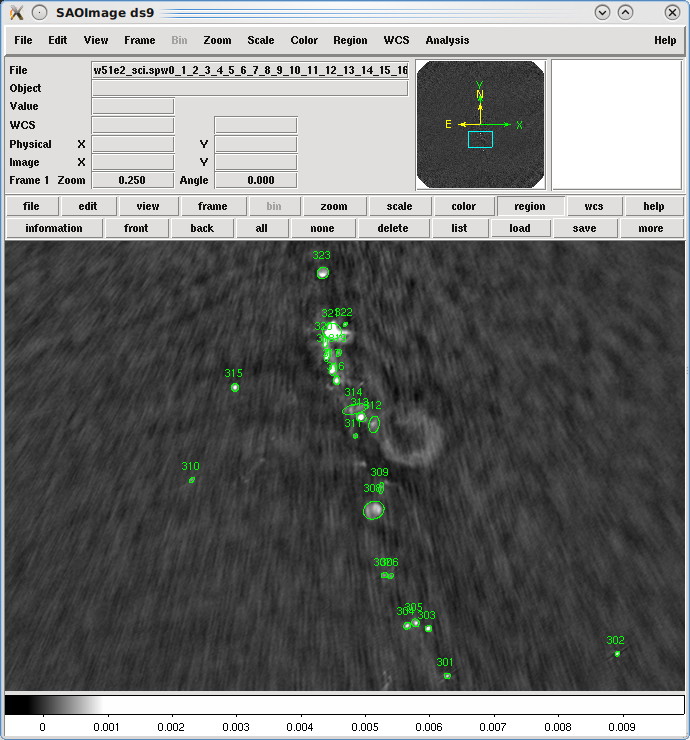

min_val = 0.00015, min_delta = 0.000225, min_npix = 7.5 seems to do the trick for band 3. The dendrogram has picked up most of the very faint point sources, and there aren't too many detections that are clearly noise. 

### Another Approach: Detection

If you know the dendrogram parameters that give you the best source detection every time, edit `./.imgfileinfo.dat` to include these values. Then, we can use `detect.py` to quickly produce a single dendrogram catalog by only specifying the region and band identifiers.

In [9]:
from detect import detect
from utils import grabfileinfo
print(grabfileinfo.__doc__)

Search imgfileinfo.dat for image information with the given region and band. Return an 8-element tuple with structure (filename, region, band, min_value, delt_frac, min_npix, nu, ppbeam).
    


In [10]:
infilename = grabfileinfo(region, band)[0]
print(infilename)

/lustre/aoc/students/bmcclell/w51/w51e2_sci.spw0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19.mfs.I.manual.image.tt0.pbcor.fits.gz


In [11]:
min_value, delt_frac, min_npix = grabfileinfo(region, band)[3:6]
print(min_value, delt_frac, min_npix)

0.00015 1.7 7.5


In [12]:
#detect(infilename, region, band, min_value=min_value, min_delta=min_value*delt_frac, min_npix=min_npix, verbose=True)

### Rejection

Now we need to reject the noisy detections.

In [13]:
from reject import reject
print(reject.__doc__)

Reject noisy detections.
    
    Parameters
    ----------
    imfile : str
        The path to the radio image file
    catfile : str
        The path to the source catalog, as obtained from detect.py
    threshold : float
        The signal-to-noise threshold below which sources are rejected
    


In [14]:
from utils import grabfileinfo, grabcatname
imfile = grabfileinfo(region, band)[0]
catfile = grabcatname(region, band)

In [15]:
#reject(imfile, catfile, 6.)

Using this grid plot alongside our DS9 window with the matching regions loaded in, we can visually inspect the sources to make sure the rejection script did its job. Anything that didn't get caught by the script can be manually accepted or rejected (already performed here). 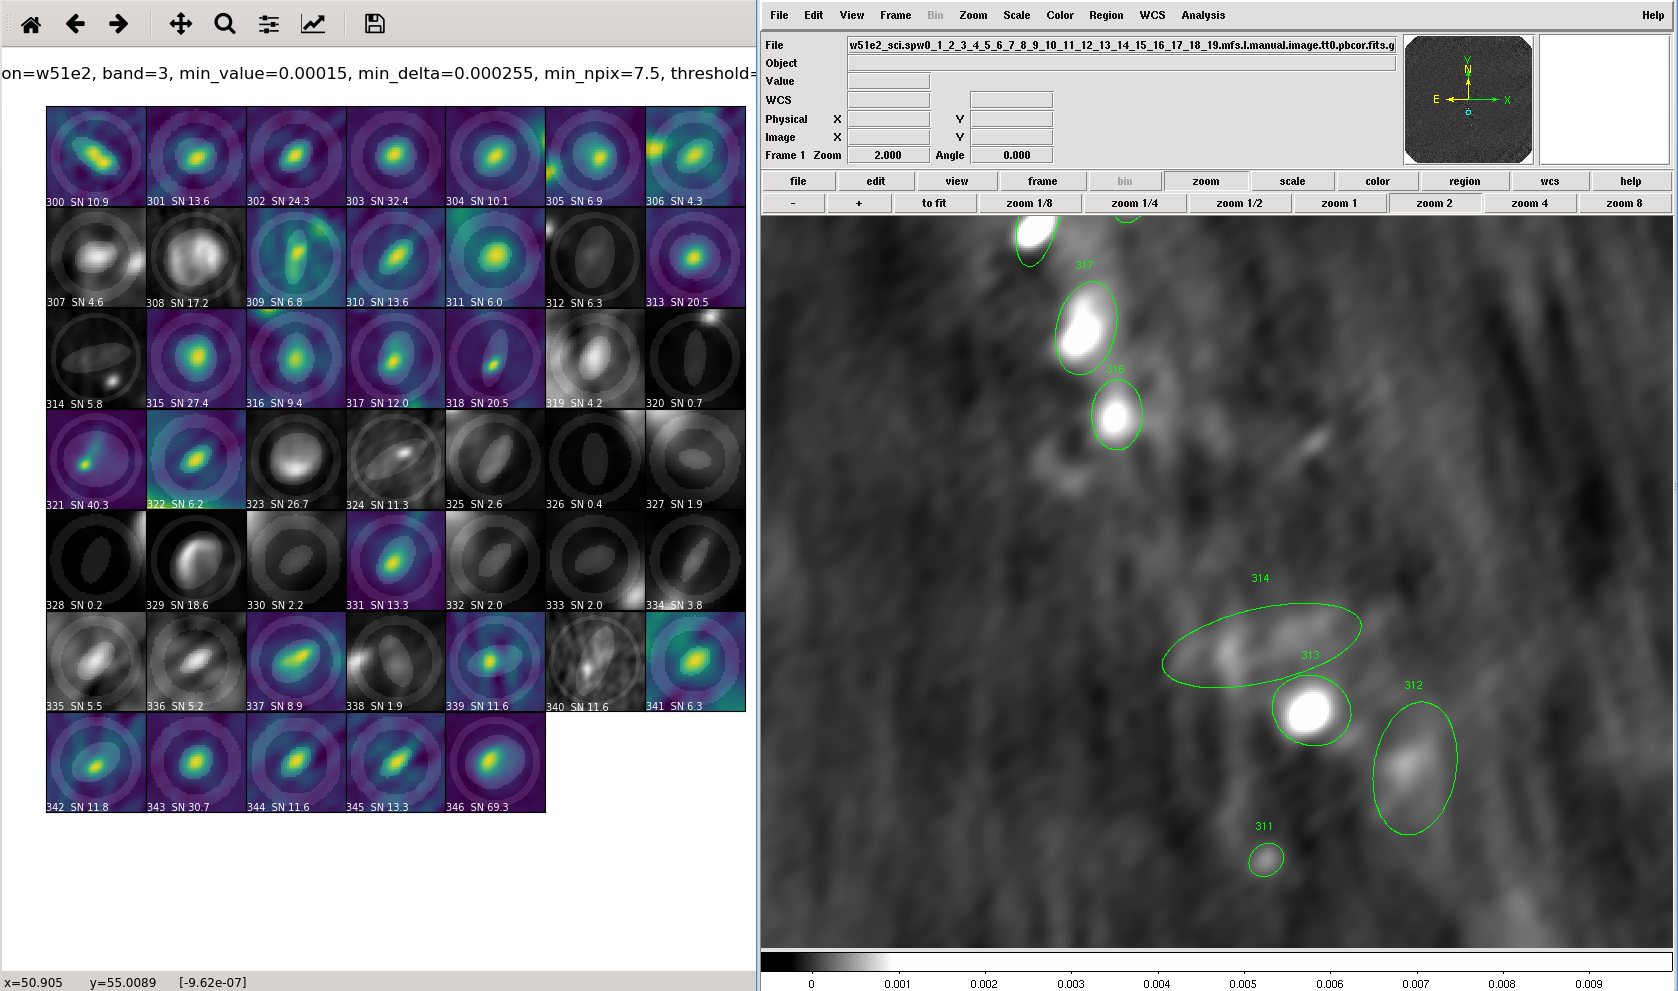

### Source matching

After repeating the procedure thusfar for other bands (in this case, just band 6), we're ready to match up the sources that were detected in both images.

In [16]:
import match
bands = [3, 6]

We need to grab the catalog names output by the rejection script, which are flagged "filtered".

In [17]:
filelist = []
for band in bands:
    filelist.append(grabcatname(region, band, flag='filtered'))
print(filelist)

['./cat/cat_regionw51e2_band3_val0.00015_delt0.000255_pix7.5_filtered.dat', './cat/cat_regionw51e2_band6_val0.000325_delt0.0005525_pix7.5_filtered.dat']


In [18]:
match.make_master_cat(filelist)

Combining matches

11 matches combined


11 sources were close enough together to be identified as the same source in both images. These sources are collapsed down into a single master catalog entry, using the smallest bounding ellipse of the two original source ellipses.

If a source is detected in one band but not the other, its information remains in the master catalog so that its flux can be measured in other bands later on.

### Flux Measurement

Using the recently produced master catalog, we can now measure the flux in a few different apertures for all sources across all bands.

In [19]:
from flux import flux
#flux(region)

### Flux Flux Plots

With the photometry performed, we can compare the fluxes between two bands.

In [20]:
from ffplot import ffplot, specindex, namedict

In [21]:
shapes = ['ellipse', 'circ1', 'circ2', 'circ3']
print(ffplot.__doc__)

Make a flux v. flux plot.
    
    Parameters
    ----------
    region : str
        The region identifier for the images
    shapes : list (dtype=str)
        A list of aperture shapes to compare
    band1 : int
        The ALMA band of observation whose flux will be on the x-axis
    band2 : int
        The ALMA band of observation whose flux will be on the y-axis
    
    Keyword Arguments
    -----------
    log : bool (default True)
        Display the plot on a log scale
    label : bool (default False)
        Draw ID labels for each source
    grid : bool (default True)
        Display a separate plot for each aperture
    peak : bool (default False)
        Use peak flux within ellipse instead of any aperture sums
    


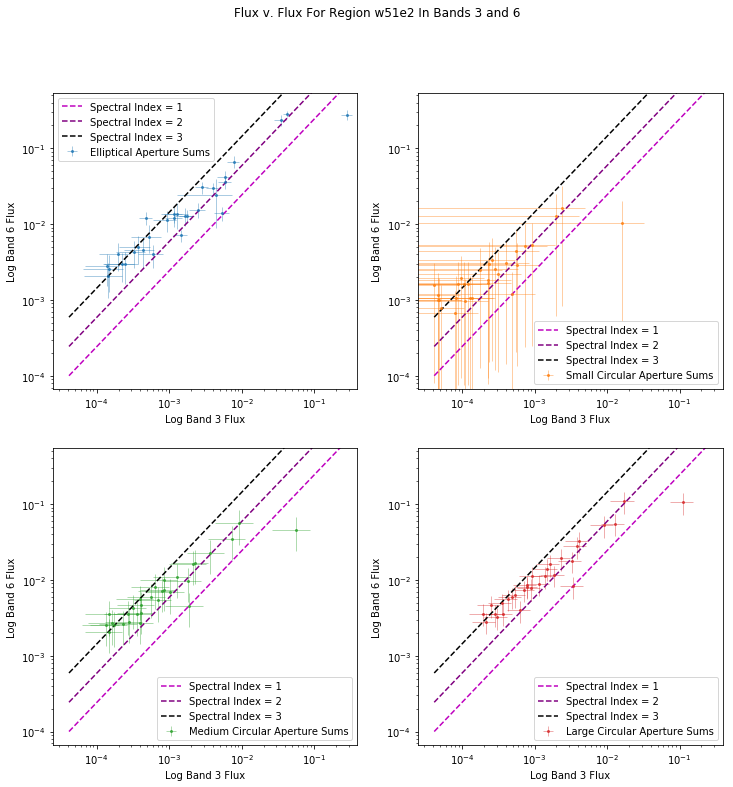

In [22]:
ffplot(region, shapes, 3, 6, grid=True, log=True)

We can also add labels to identify which sources are which, and compare with the images in DS9.

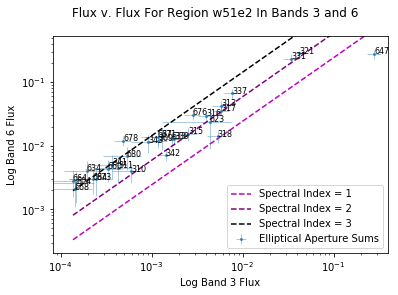

In [23]:
ffplot(region, ['ellipse'], 3, 6, grid=False, label=True)

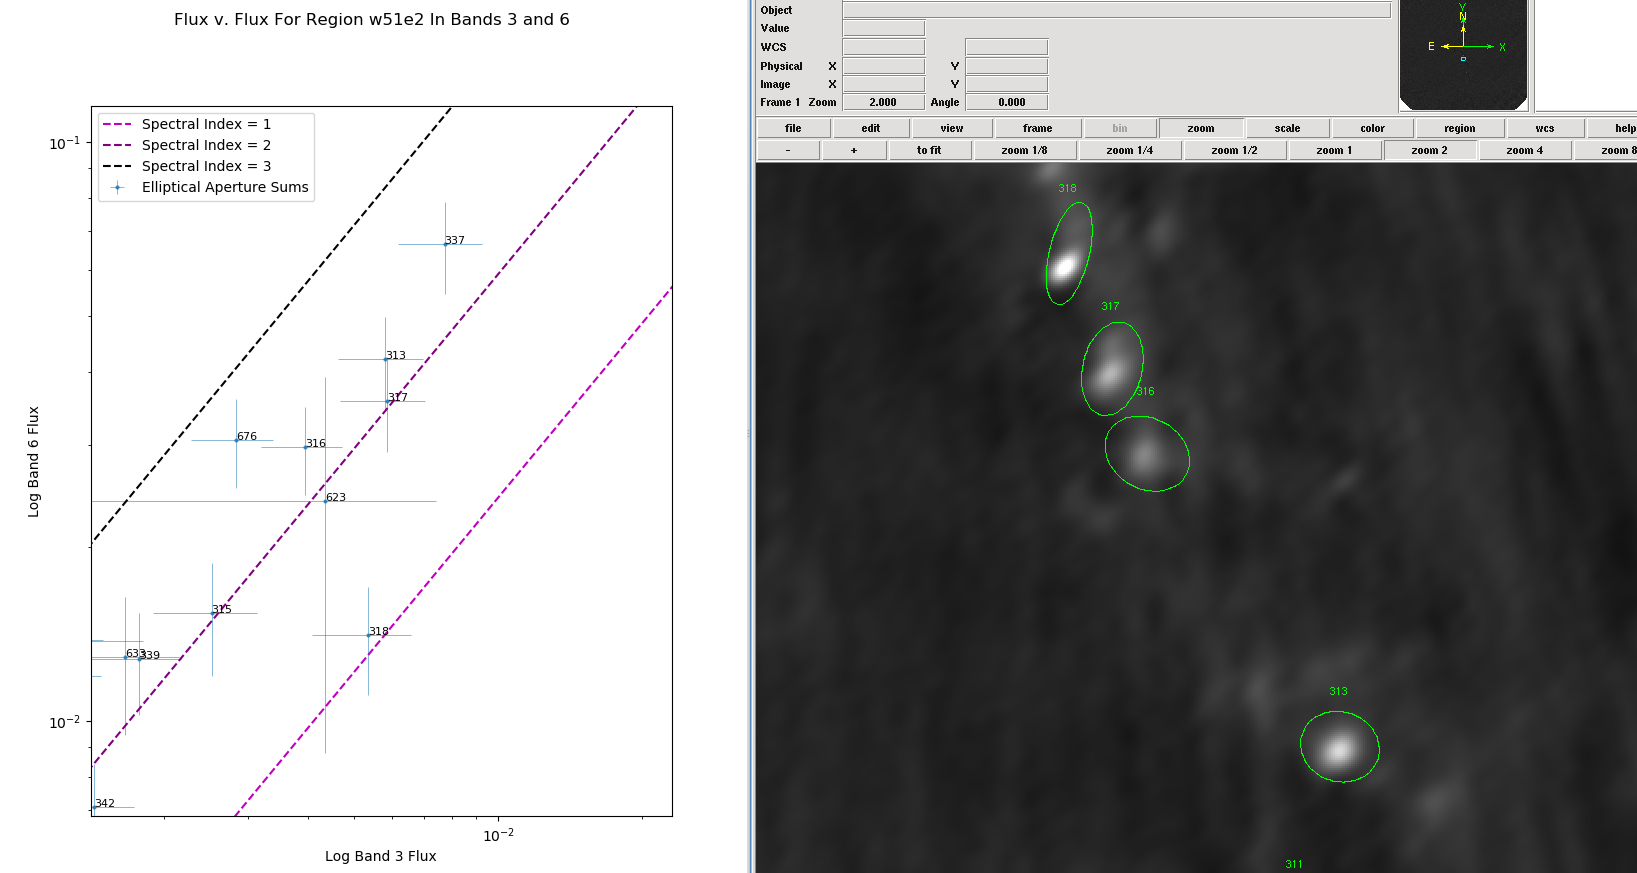

### Flux Histograms

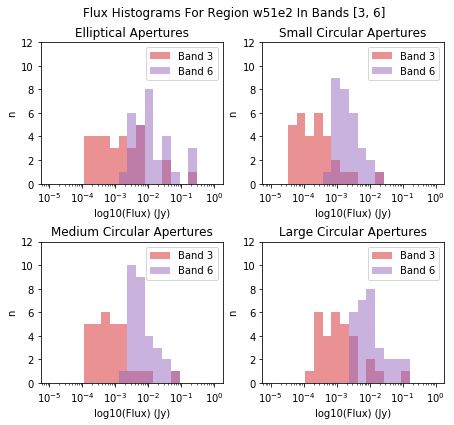

In [24]:
from hist import hist
import matplotlib.pyplot as plt
hist(region, bands, shapes)
plt.show()